The functions and cell calls below are all used to generate the three plots requested in Step 2. They use the data generated from wildfire_data_generator.ipynb and EPA_AQI_data_generator.ipynb

In [1]:
# standard imports used for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

The function below, make_histogram_of_fires_by_distance, is used to create the histogram requested. For every 50 miles, it counts the number of fires within that bucket from Sioux Falls. It then outputs it as histogram with a line at 650 miles which is the limit we use for all further analysis.

In [2]:
def make_histogram_of_fires_by_distance(df, city):
    """
    Takes in a dataframe containing information about wildfires, 
    also takes in the city name

    Parameters:
        - df: Dataframe with wildfire information
        - city: Name of city

    Returns a histogram plot showing the number of fires every 50 
    miles from the city chosen up to 1850 miles
    """
    # Create a histogram
    plt.figure(figsize=(22, 6))
    plt.hist(df[f"average_distance_from_{city}"], bins=range(0, 1850, 50), edgecolor='black')

    # Add a vertical dashed line at 650 miles
    plt.axvline(x=650, color='red', linestyle='--', linewidth=2, label='Distance cutoff')


    # Add labels and title
    plt.title('Histogram of Fires Occurring by Distance (0-1800 miles)')
    plt.xlabel('Distance (miles)')
    plt.ylabel('Number of Fires')
    plt.xticks(range(0, 1850, 50))  # Set x-ticks at intervals of 50 miles

    # Show grid for better readability
    plt.grid(axis='y')

    # Add legend to indicate what the red line represents
    plt.legend()

    # Display the histogram
    plt.show()

The function, make_time_series_acres_burned, is used to make the second plot - a time series for the total acres burned per year for my city. The first filters the data to go from 1800 miles to <= 650 miles.

In [3]:
def make_time_series_acres_burned(df, city):
    """
    Takes in a dataframe containing information about wildfires, 
    also takes in the city name

    Parameters:
        - df: Dataframe with wildfire information
        - city: Name of city

    Returns a time series line plot showing how the total acreage burned changes year to year.
    """
    # Step 1: Filter the DataFrame for fires occurring <= 650 miles
    wildfire_data = df[df[f"average_distance_from_{city}"] <= 650]

    # Step 2: Group by 'Fire_Year' and sum the 'GIS_acres'
    acres_per_year = wildfire_data.groupby("Fire_Year")["GIS_Acres"].sum().reset_index()

    # Step 3: Plot the data
    plt.figure(figsize=(25, 6))
    plt.plot(acres_per_year["Fire_Year"], acres_per_year["GIS_Acres"], marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.title('Total Acres Burned Per Year for Fires <= 650 Miles')
    plt.xlabel('Year')
    plt.ylabel('Total Acres Burned')
    # Rotate x-ticks by 45 degrees
    plt.xticks(acres_per_year["Fire_Year"], rotation=45)

    # Show grid for better readability
    plt.grid()

    # Display the time series graph
    plt.show()

The function below plots the third plot requested, a time series graph containing fire smoke estimates and AQI estimates. This function is a little complicated and has some important decisions made in order to create the best smoke estimate. Ultimately, I understand these decisions are gross simplifications - but the intent is to produce a working smoke estimate that attempts approach the real-world value (AQI)

First off, I sum my smoke metric for all fires year to year. Therefore, I'm attempting to estimate the smoke on October 31st. I assume all fires that start within the fire season end on October 31st (simplification).

There are serious implications as a result of this assumption. Briefly, it assumes that the smoke from fires in the early season don't dissipate. It assumes fires promptly go out on October 31st, and it assumes the metric itself is correct (area of fire / distance from city^2).

I then compare my smoke estimate to the AQI estimate on October 31st. If there is no data on October 31st, I compare it to the nearest day to October 31st. This assumes that the AQI has very little variation (when in reality it has sizeable variation due to weather effects).

Finally, I implement a constant growth factor of 5000 multiplied to my smoke estimate metric. Ultimately, my metric is arbitrary with arbitrary units that aren't able to be readily converted to AQI estimates. Therefore we're mostly interested in the difference year-to-year and whether it resembles the AQI estimate year to year.

In conclusion, this plot simply attempts to estimate the smoke year to year at the end of the fire season, which based on the plot - it struggles to do. There are some years where the results are closer to the EPA published values, but some years where the two numbers are drastically different. 

In [4]:
def fire_smoke_estimate_with_aqi(wildfire_df, aqi_df, city_name, end_season_date = [10, 31], smoke_scale_factor = 5000):
    """
    Takes in a dataframe containing information about wildfires, dataframe containing AQI information for given city,
    also takes in the city name, the end of the season date, and a "smoke_scale_factor" described above.

    Parameters:
        - wildfire_df: Dataframe with wildfire information
        -aqi_df: Dataframe with AQI information
        - city_name: Name of city
        - end_season_date: The date the fire season ends (10/31 for our example)
        - smoke_scale_factor: Arbitrary value multiplied to the smoke estimate to get it within the magnitude of the AQI

    Returns a time series line plot comparing the AQI to our smoke estimate.
    """
    wildfire_df = wildfire_df[wildfire_df[f"average_distance_from_{city_name}"] <= 650]
    # Group by "year" and sum "smoke_impact"
    smoke_impact_by_year = wildfire_df.groupby("Fire_Year", as_index=False)["smoke_impact"].sum()

    # Optionally, rename the column for clarity
    smoke_impact_by_year.rename(columns={"smoke_impact": "total_smoke_impact"}, inplace=True)
    aqi_df['max_aqi'] = aqi_df['max_aqi'].fillna(method='ffill')
    aqi_df.index = pd.to_datetime(aqi_df.index)
    # Initialize a list to store results
    end_of_season_data = []
    # Iterate over unique years in AQI_data
    for year in year_list:
        # Create a timestamp for October 31st
        end_date = pd.Timestamp(year, end_season_date[0], end_season_date[1])
        
        # Get data for the current year
        year_data = aqi_df[aqi_df.index.year == year]
        
        # Check for end date
        if end_date in year_data.index:
            # If end date data is available, use it
            max_aqi_value = year_data.loc[end_date, 'max_aqi']
        else:
            # If not available, find the closest valid date
            closest_date = year_data.last_valid_index()  # Get the last valid index within the year
            if closest_date is not None:
                max_aqi_value = year_data.loc[closest_date, 'max_aqi']
            else:
                max_aqi_value = None  # In case there is no valid date
        
        # Append the result for this year to the list
        end_of_season_data.append({'Year': year, 'Max AQI': max_aqi_value})

    # Convert the list to a DataFrame
    end_of_season_data = pd.DataFrame(end_of_season_data)
    smoke_impact_by_year["total_smoke_adj"] = smoke_impact_by_year["total_smoke_impact"] * smoke_scale_factor
    # PLOT 3

    # Create a figure for the plots
    plt.figure(figsize=(16, 6))  # Make the figure wider

    # Plot the max AQI per year
    plt.plot(end_of_season_data["Year"], end_of_season_data['Max AQI'], marker='o', label='Max AQI', color='blue')  # Line plot with markers

    # Plot the total smoke adjusted values
    plt.plot(smoke_impact_by_year['Fire_Year'], smoke_impact_by_year['total_smoke_adj'], marker='x', color='orange', label='Total Smoke Adjusted')  # Line plot with markers

    # Title and labels
    plt.title('Max AQI at End of Season (Oct 31 or Closest Valid Date) and Total Smoke Impact Over Time')  # Title of the plot
    plt.xlabel('Year')  # X-axis label
    plt.ylabel('Value')  # Y-axis label

    plt.grid()  # Add a grid for better readability
    plt.legend()  # Add a legend to differentiate between lines
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot

The cells below load the data, then generate the plots

In [5]:
AQI_data = pd.read_csv("data/AQI_Sioux_Falls_1980_2021.csv", index_col=0)
wildfire_data = pd.read_csv("data/wildfire_processed.csv", index_col=0)

C:\Users\PC\AppData\Local\Temp\ipykernel_28816\482574214.py:2: DtypeWarning: Columns (14,21,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  wildfire_data = pd.read_csv("data/wildfire_processed.csv", index_col=0)


The cell below makes the first plot

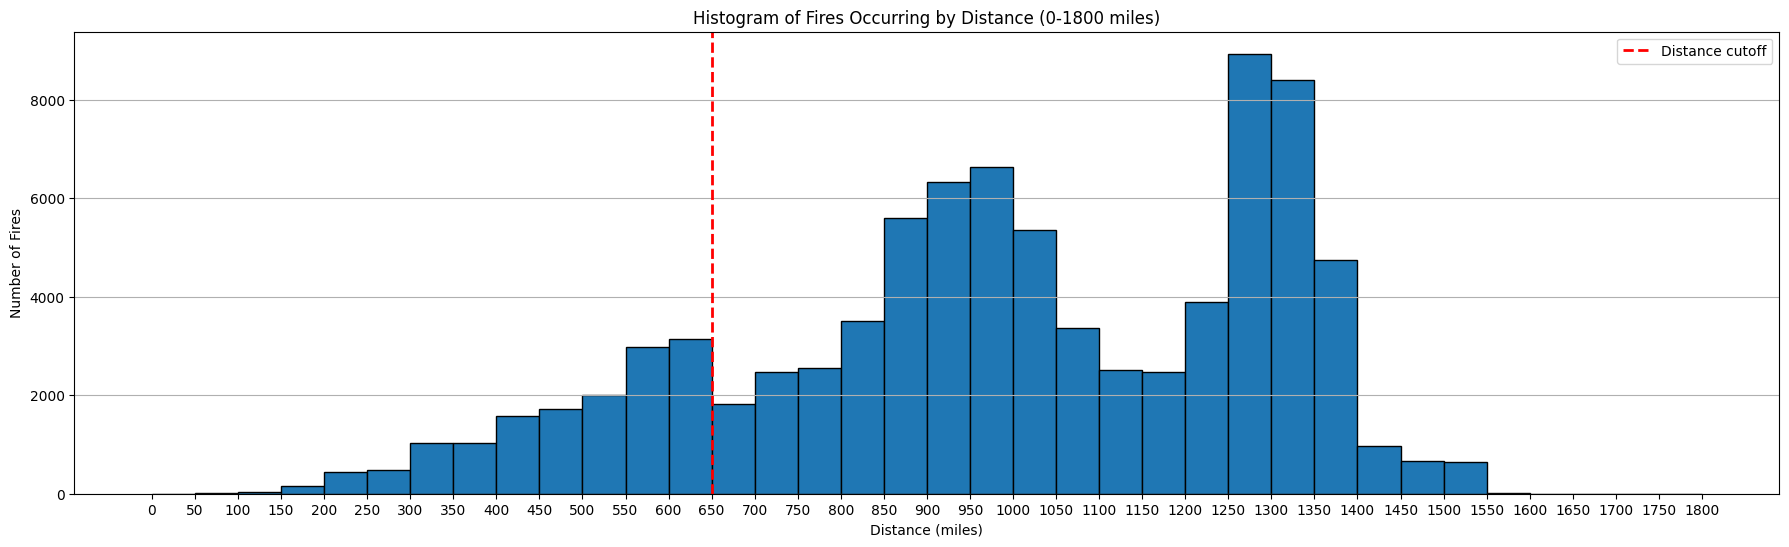

In [6]:
make_histogram_of_fires_by_distance(wildfire_data, "Sioux_Falls")

The cell below makes the second plot

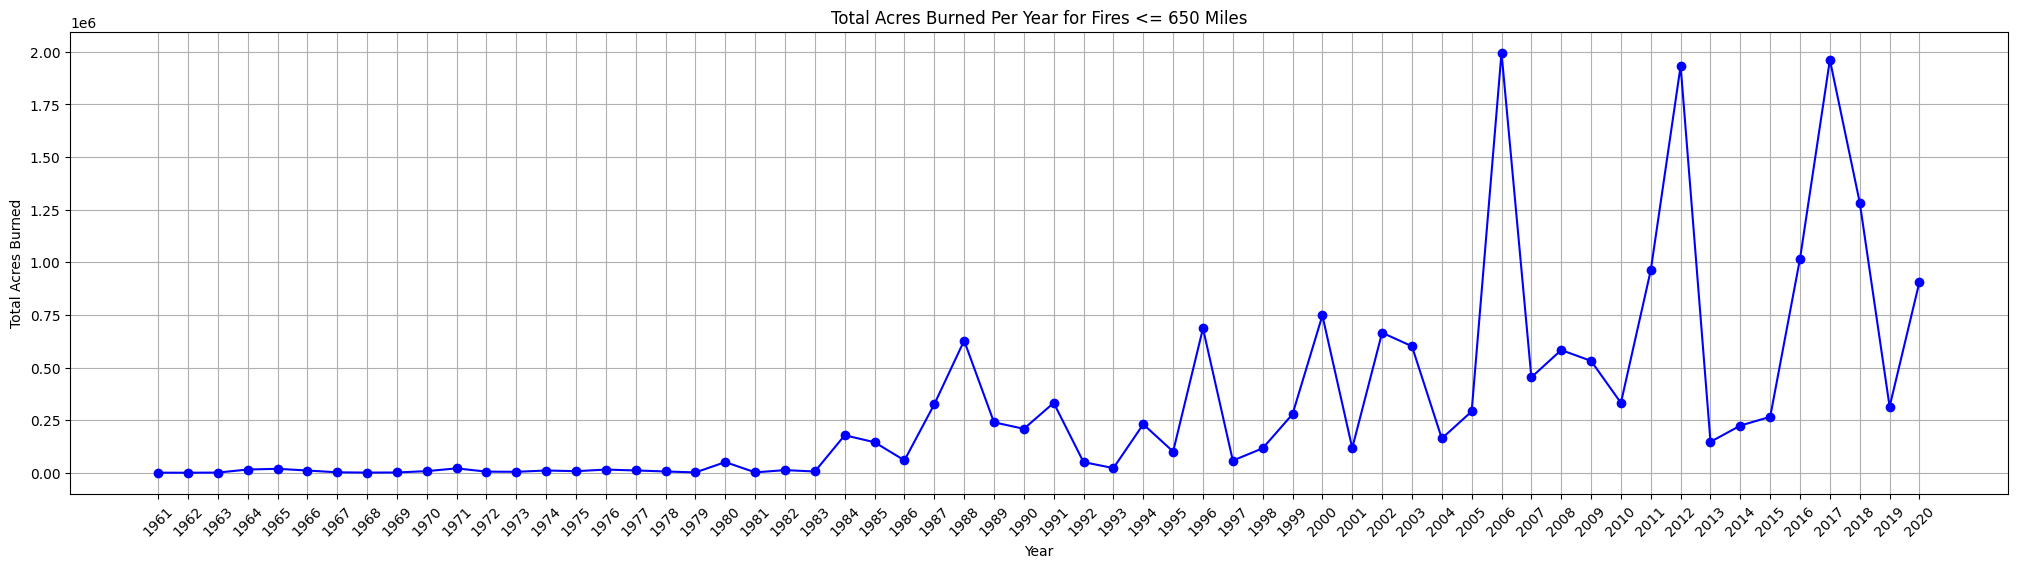

In [7]:
make_time_series_acres_burned(wildfire_data, "Sioux_Falls")

The cell below shows how the end_season_month_day variable works - this could be changed if the user wants the season date to be different. Naturally, this would also need to be changed when generating the wildfire data.

The smoke_estimate_scale factor is also adjustable - it's currently set to 5000 so both lines are visible and can be compared.

In [8]:
end_season_month_day = [10, 31]
fire_smoke_estimate_with_aqi(wildfire_data, AQI_data, "Sioux_Falls", end_season_month_day, 5000)

C:\Users\PC\AppData\Local\Temp\ipykernel_28816\695815322.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aqi_df['max_aqi'] = aqi_df['max_aqi'].fillna(method='ffill')


NameError: name 'year_list' is not defined